In [2]:
import pandas as pd
import numpy as np
import os
import shutil
import glob
home_dir = os.path.expanduser("~")
content_dir = '/content'
print('Home path is'+home_dir)

Home path is/root


Data preparation

In [7]:
# Kaggle API token

! pip install -q kaggle
from google.colab import files
if os.path.isfile('./kaggle.json') == False:
    files.upload()
print('Kaggle credential uploaded')

Kaggle credential uploaded


In [9]:
data_path = content_dir +'/data'
print('Data is stored at: '+data_path)
os.makedirs(content_dir+'/.kaggle',exist_ok = True)
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
os.system('kaggle competitions download -c mais202fall2021 -p '+data_path)
fname_zip = glob.glob(data_path+'/'+'*.zip'); print(fname_zip)
for i in range(len(fname_zip)):
    shutil.unpack_archive(fname_zip[i], './data')

Data is stored at: /content/data
['/content/data/test_images.npy.zip', '/content/data/train_images.npy.zip']


In [30]:
# show_image function 

import matplotlib.pyplot as plt

def show_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap="Greys")
    plt.show()


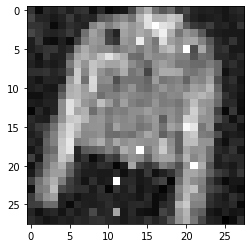

(50000, 28, 28)
(50000, 1)


In [31]:
x_train = np.load(data_path+'/train_images.npy')
y_train = pd.read_csv(data_path+'/train_labels.csv', index_col=0)
y_train = pd.DataFrame(y_train).to_numpy()

show_image(x_train[1])

# print(y_train)
print(x_train.shape)
print(y_train.shape)

Approach 1

In [29]:
from tensorflow.keras.utils import to_categorical